In [4]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# from matplotlib.ticker import StrMethodFormatter
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.ticker import NullFormatter
from sklearn.metrics import auc
from scipy.integrate import quad
import matplotlib.pylab as pl
import scipy as sp
import math

plt.rcParams['axes.labelpad'] = 20
plt.rcParams.update({'font.size': 12, 'font.family': 'Verdana'})
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


In [5]:
def log_likelihood(theta, firing_rates, kappa, theta_i):
    diff = np.cos(theta - theta_i)
    return kappa * firing_rates.dot(diff)

def tuning_curve(theta, kappa, theta_i):
    return np.exp(kappa * np.cos(theta - theta_i) - 1)

def log_tuning_curve(theta, kappa, theta_i):
    return kappa * np.cos(theta - theta_i) - 1

def rho(i, j, rho_max):
    return rho_max * np.exp(delta * np.cos(theta_pref[i] - theta_pref[j]) - 1)

In [8]:
"""
Fig 2B - Schematic
"""

kappa = 5    # width parameter of tuning curves
index = 80   # index of presented stimulus 

theta = np.radians(np.linspace(-180, 180, 200))       # angles of all possible stimuli 
theta_i = np.radians(np.linspace(-180, 180, 200))     # direction selectivity of each neuron 

theta_samples = np.linspace(0, len(theta)-1, 11).astype(int)   # samples to display on figure 

firing_rates = np.array([tuning_curve(theta, kappa, th) for th in theta_i])

weights = [log_tuning_curve(theta, kappa, th) for th in theta_i]

log_likelihoods = [log_likelihood(th, firing_rates[index], kappa, theta_i) for th in theta]


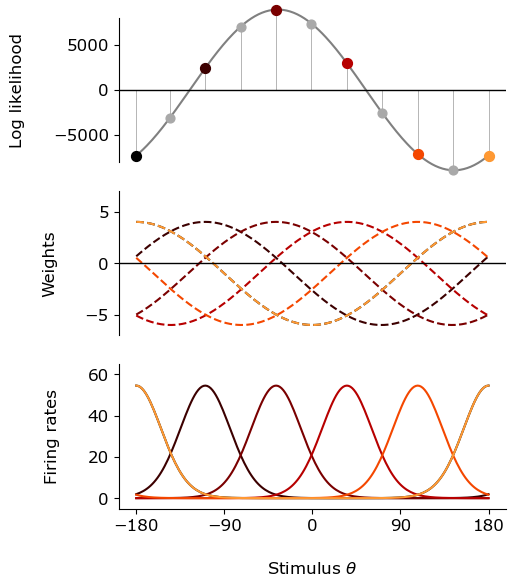

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(5, 6.5), dpi=100)

colors = pl.cm.gist_heat(np.linspace(0, 0.8, len(theta_samples[::2])))

for ind, val in enumerate(theta_samples):
    axes[0].scatter(np.degrees(theta[val]), log_likelihoods[val], color='darkgray', lw=1, s=40, zorder=3, clip_on=False)
    axes[0].plot([np.degrees(theta[val]), np.degrees(theta[val])], [0, log_likelihoods[val]], color='darkgray', lw=0.6, clip_on=False)
for ind, val in enumerate(theta_samples[::2]):
    axes[0].scatter(np.degrees(theta[val]), log_likelihoods[val], color=colors[ind], lw=1, s=50, zorder=3, clip_on=False)
axes[0].plot(np.degrees(theta), log_likelihoods, c='gray', clip_on=False)
axes[0].set_ylabel(r'Log likelihood')
axes[0].set_ylim(-8000, 8000)

for ind, val in enumerate(theta_samples[::2]):
    axes[1].plot(np.degrees(theta), weights[val], '--', color=colors[ind], lw=1.5)
axes[1].set_ylabel(r'Weights')
axes[1].set_ylim(-7, 7)

for ind, val in enumerate(theta_samples[::2]):
    axes[2].plot(np.degrees(theta), firing_rates[val], color=colors[ind])

axes[2].set_xlabel(r'Stimulus $\theta$')
axes[2].set_ylabel(r'Firing rates')
axes[2].set_ylim(-5, 65)
sns.despine(ax=axes[2], top=True, right=True, left=False, bottom=False)

for ax in axes.flatten():
    ax.set_xticks([-180, -90, 0, 90, 180])    

for ax in [axes[0], axes[1]]:
    ax.axhline(0, c='k', lw=1)
    ax.get_xaxis().set_ticks([])
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)

plt.show()

In [7]:
"""
Fig 3A - ROC curve
"""

N = 200         # number of neurons
kappa = 3       # concentration parameter for tuning curve
R_min = 0       # min firing rate
R_max = 60      # max firing rate
rho_max = 0.2   # max pairwise correlation  
delta = 0.1     # concentration parameter for correlations 
t = 0.008       # time interval

theta = np.radians(90)                                 # direction of motion of dots
theta_pref = np.radians(np.linspace(-180, 180, N))     # direction selectivity of each neuron 
coherences = [0.03, 0.06, 0.13, 0.25]                  # coherence of moving dots 

firing_rates = np.array([tuning_curve(theta, kappa, th) for th in theta_pref])
diff = np.cos(theta - theta_pref)
mean_sum = firing_rates.dot(diff)

temp = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        rho_ij = rho(i, j, rho_max)
        f_i = tuning_curve(theta, kappa, theta_pref[i])
        f_j = tuning_curve(theta, kappa, theta_pref[j])
        temp[i, j] = rho_ij * np.sqrt(f_i * f_j) * np.cos(theta - theta_pref[i]) * np.cos(theta - theta_pref[j])

var_sum = temp.sum()

# calculate hit rate and false alarm rate for different thresholds 

sigma_min = 12

zs = np.arange(-50, 180, 1)   # detection thresholds 

alphas = np.zeros((len(coherences), len(zs)))
betas = np.zeros((len(coherences), len(zs)))

x = np.linspace(R_min - 5*sigma_min, R_min + 30*sigma_min, 1000)

for i, C in enumerate(coherences):
    
    mean = kappa * C * R_max * t * mean_sum
    variance = kappa**2 * C * R_max * t * var_sum 

#     plt.plot(x, sp.stats.norm.pdf(x, mean, np.sqrt(variance)))

    for j, z in enumerate(zs):

        alphas[i, j] = (1 - math.erf((z - R_min) / (sigma_min * np.sqrt(2)))) * 0.5                # false alarm rate - area under null curve to right of z
        betas[i, j] =  ((1 - math.erf((z - mean) / (np.sqrt(variance) * np.sqrt(2)))) * 0.5)       # hit rate - area under signal curve to right of z

# plt.plot(x, sp.stats.norm.pdf(x, R_min, sigma_min), color='gray')
# for z in zs[::10]:
#     plt.axvline(z, color='k', alpha=0.3)
# plt.show()
 
alphas = np.insert(alphas, 0, np.linspace(0, 1, len(zs)), axis=0) 
betas = np.insert(betas, 0, np.linspace(0, 1, len(zs)), axis=0) 

AUCs = [auc(alphas[i], betas[i]) for i in range(len(alphas))]

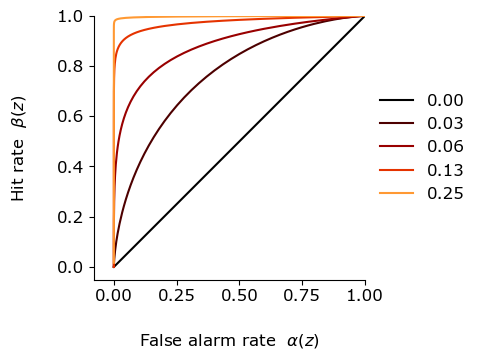

In [8]:
colors = pl.cm.gist_heat(np.linspace(0, 0.8, 5))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=100)

ax.plot(alphas[0], betas[0], color=colors[0], label='0.00')

for i, C in enumerate(coherences):
    ax.plot(alphas[i+1], betas[i+1], color=colors[i+1], label='%.2f' %C)
    
ax.set_xlim(-0.08, 1)
ax.set_ylim(-0.05, 1)

ax.set_xlabel(r'False alarm rate  $\alpha(z)$')
ax.set_ylabel(r'Hit rate  $\beta(z)$')
ax.set_aspect('equal') 
ax.legend(loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
plt.show()

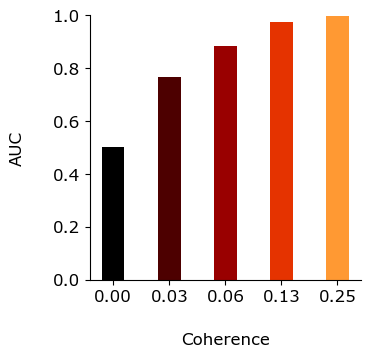

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=100)

ax.bar(np.arange(len(alphas)), AUCs, color=colors, width=0.4)

ax.set_xlabel('Coherence')
ax.set_ylabel('AUC')
ax.set_ylim(0, 1)

ax.set_xticks(np.arange(len(alphas)))
ax.set_xticklabels(['0.00'] + coherences)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
plt.show()


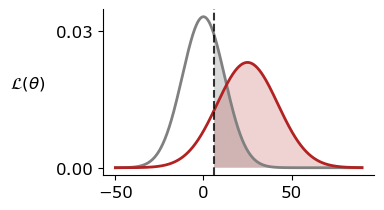

In [13]:
# ROC schematic 

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.2), dpi=100)

C = 0.06
z = 400

x = np.linspace(-50, 90, 1000)

mean = kappa * C * R_max * t * mean_sum
variance = kappa**2 * C * R_max * t * var_sum 

ax.plot(x, sp.stats.norm.pdf(x, R_min, sigma_min), color='gray', lw=2)
ax.plot(x, sp.stats.norm.pdf(x, mean, np.sqrt(variance)), color='firebrick', lw=2)
ax.axvline(x[z], c='k', ls='--', alpha=0.8)

ax.fill_between(x[z:], 0, y2=sp.stats.norm.pdf(x[z:], R_min, sigma_min), fc='gray', alpha=0.3)
ax.fill_between(x[z:], 0, y2=sp.stats.norm.pdf(x[z:], mean, np.sqrt(variance)), fc='firebrick', alpha=0.2)

ax.set_yticks([0, 0.03])
ax.set_ylabel(r'$\mathcal{L}(\theta)$', rotation=0)

plt.locator_params(axis='y', nbins=3)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
plt.show()

In [16]:
"""
Fig 3C - Discrimination between two alternatives
"""

# angular_sep = np.radians([12, 22.5, 45, 90, 180])
angular_sep = np.radians(np.linspace(10, 180, 10))

theta_1 = np.radians(0)              # target angle
theta_2s = theta_1 - angular_sep     # opposing angle 

delta = 0.8      # concentration parameter for correlations   
t = 0.005        # time interval
C = 0.2          # coherence
 
firing_rates = np.array([tuning_curve(theta_1, kappa, th) for th in theta_pref])


x = np.linspace(-80, 300, 1000)

colors = pl.cm.gist_heat(np.linspace(0, 0.8, len(angular_sep)))

# fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=100)

Ps = []
for k, angle in enumerate(angular_sep):
    
    delta_theta = (theta_1 - theta_2s[k])/2
    theta_m = (theta_1 + theta_2s[k])/2 

    temp = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            rho_ij = rho(i, j, rho_max)
            f_i = tuning_curve(theta_1, kappa, theta_pref[i])
            f_j = tuning_curve(theta_1, kappa, theta_pref[j])
            temp[i, j] = rho_ij * np.sqrt(f_i * f_j) * np.sin(theta_pref[i] - theta_m) * np.sin(theta_pref[j] - theta_m)

    var_sum = temp.sum()

    var_LR = (2 * kappa * np.sin(delta_theta))**2 * C * R_max * t * var_sum                                         # variance of log LR
    mean_LR = 2 * kappa * C * R_max * np.sin(delta_theta) * t * np.dot(firing_rates, np.sin(theta_pref - theta_m))  # mean of log LR

#     ax.plot(x, sp.stats.norm.pdf(x, mean_LR, np.sqrt(var_LR)), color=colors[k])  # pdf of log LR 

    def f(x):
        return np.exp(- (x - mean_LR)**2 / (2 * var_LR))
    
    res, err = quad(f, 0, np.inf)                              # integral of log LR from 0 to infinity 
    Ps.append((1 / np.sqrt(2 * np.pi * var_LR)) * res)         # performance metric


# ax.axvline(0, c='grey', ls='--', lw=1)
# ax.set_ylim(-0.002, 0.05)

# ax.set_xlabel(r'$\log \; \mathcal{L}(\theta_1) - \log \; \mathcal{L}(\theta_2)$' )
# ax.set_ylabel(r'p(Log LR)')

# plt.locator_params(axis='y', nbins=2)
# plt.locator_params(axis='x', nbins=3)
# sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
# plt.show()
    

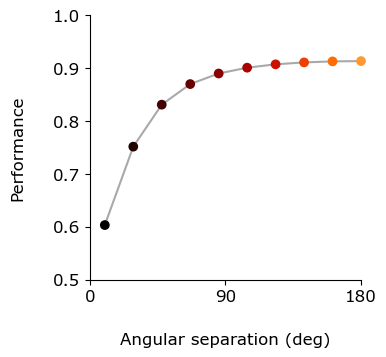

In [18]:
colors = pl.cm.gist_heat(np.linspace(0, 0.8, len(angular_sep)))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=100)

ax.plot(np.degrees(angular_sep), Ps, color='darkgrey')
ax.scatter(np.degrees(angular_sep), Ps, color=colors, zorder=3, clip_on=False)

ax.set_xlim(0, 180)
ax.set_ylim(0.5, 1)
ax.set_xticks([0, 90, 180])    

ax.set_xlabel(r'Angular separation (deg)')
ax.set_ylabel(r'Performance')
# ax.set_aspect('equal') 
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
plt.show()